In [2]:
import networkx as nx
import re
from collections import deque # for popping from the left of a list
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
SEQUENCE = "[XIC(A) [XIC(B) ,XIC(C) ] ,XIO(A) XIC(D) ]TON(E);"
STARTING_NODE_NAME = 'Start'

# We remove spaces as they seem inconsistent and we don't need them.
spaces_removed_seq = re.sub(' ','',SEQUENCE)

In [6]:
# Instantiate our directional graph and add a starting node.
G = nx.DiGraph()
G.add_node(STARTING_NODE_NAME)

# We'll do this recursively in case there are a lot of nested
# parallel structures, so we create a tuple with the node we're
# starting from and the string we'll be working from. We're storing
# it as a deque to be able to efficiently 'pop' the next list from the
# left side without having to recopy the list. Probably unnecessary
# but it's fun to use the optimized collections.
paths_to_traverse = deque([(STARTING_NODE_NAME,spaces_removed_seq)])

In [7]:
# Assuming all nodes terminate at that final node beginning with a T
# we'll keep track of stragglers here.
nodes_needing_termination = set()

# Now we begin our recursion
while paths_to_traverse:
    
    # Variables we'll need to handle branching and saving
    # 'closures' of subsequences we'll revisit on another
    # pass.
    brackets_needing_closure = 0
    start_of_closure_to_buffer = 0
    branching_from_node = None
    
    # We get our currently active node and the sequence we're parsing
    current_node_name, work_seq = paths_to_traverse.popleft()
    print(f"picking up from {current_node_name} to map sequence: {work_seq}")

    # Now for the main loop. We need the index and we'll go character by character
    for idx,char in enumerate(work_seq):
        
        # An X is the start of a new node, so we'll make it
        # and add an edge from our currently active node,
        # then update this new node to be our active one.
        if char in {'X'} and brackets_needing_closure <= 1:
            next_node_name = work_seq[idx:idx+6]
            G.add_node(next_node_name)
            G.add_edge(current_node_name, next_node_name)
            print(f"adding edge from {current_node_name} to {next_node_name}")
            try:
                # If a node has a 'follower' it's no longer
                # in need of final termination
                nodes_needing_termination.remove(current_node_name)
            except:
                pass
            # Now the next node in sequence becomes our 'active'
            # node, and we add it to require termination
            current_node_name = next_node_name
            nodes_needing_termination.add(current_node_name)
            print(f"working from {current_node_name}")
        # An open bracket says we're starting a nested structure,
        # so let's keep track of how deep we are. We only want to
        # handle one layer of parallelization at a time, so if we
        # go deeper than that, we'll focus on saving the deeper string
        # for another pass later on.
        elif char == '[':
            brackets_needing_closure += 1
            if brackets_needing_closure == 1:
                branching_from_node = current_node_name
            elif brackets_needing_closure == 2:
                start_of_closure_to_buffer = idx
        # If we back out to be back on our current top level of the sequence
        # (or one layer deep in brackets), we can go ahead and write that
        # deeper structure to our list of sequences to revisit.
        elif char == ']':
            brackets_needing_closure -= 1
            if brackets_needing_closure == 1:
                paths_to_traverse.append((current_node_name,work_seq[start_of_closure_to_buffer:idx+1]))
        # A comma tells us to stop working from the currently active path and pick up
        # from the last branch
        elif char ==',' and brackets_needing_closure <= 1:
            current_node_name = branching_from_node
            print(f"picking back up from {current_node_name}")
        # The terminating node (if that's what T stands for) tells us
        # to add that final node
        elif char =='T':
            terminating_node_name = work_seq[idx:idx+6]
            G.add_node(terminating_node_name)

# Then we terminate all our loose ends.
for unterminated_node in nodes_needing_termination:
    G.add_edge(unterminated_node, terminating_node_name)

picking up from Start to map sequence: [XIC(A)[XIC(B),XIC(C)],XIO(A)XIC(D)]TON(E);
adding edge from Start to XIC(A)
working from XIC(A)
picking back up from Start
adding edge from Start to XIO(A)
working from XIO(A)
adding edge from XIO(A) to XIC(D)
working from XIC(D)
picking up from XIC(A) to map sequence: [XIC(B),XIC(C)]
adding edge from XIC(A) to XIC(B)
working from XIC(B)
picking back up from XIC(A)
adding edge from XIC(A) to XIC(C)
working from XIC(C)


(I'm pretty sure NetworkX / PyPlot has some hierarchy so you could get this to draw more sequentially left to right rather than this spring, but I'll leave that to you to sort out, if you even need that. But at least you can see that the correct nodes connect.)

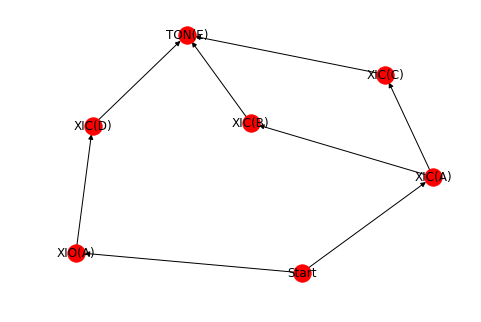

In [8]:
nx.draw(G, with_labels=True)
plt.show()